Cell 1: Import Libraries


In [18]:
# Import essential libraries for data handling, visualization, and natural language processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
import spacy
from tqdm.notebook import tqdm

# Import NLP tools from NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Import machine learning tools from sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Cell 2: Load Data

In [2]:
# Upload the CSV file
from google.colab import files
uploaded = files.upload()

# Read the uploaded CSV file
file_name = list(uploaded.keys())[0]  # Get the uploaded file name
elon_tweets = pd.read_csv(file_name, encoding='latin', on_bad_lines='skip')

# Display the first few rows of the dataset
print(elon_tweets.head())


Saving Elon_musk.csv to Elon_musk.csv
   Unnamed: 0                                               Text
0           1                             @kunalb11 Im an alien
1           2  @ID_AA_Carmack Ray tracing on Cyberpunk with H...
2           3                @joerogan @Spotify Great interview!
3           4                    @gtera27 Doge is underestimated
4           5  @teslacn Congratulations Tesla China for amazi...


Cell 3: Data Cleaning - Remove Unnecessary Columns

In [3]:
# Remove unnecessary columns and rename for clarity
elon_tweets.drop(['Unnamed: 0'], axis=1, inplace=True)
elon_tweets.rename(columns={'Text': 'TweetContent'}, inplace=True)

# Display the updated DataFrame
elon_tweets.head()

,TweetContent
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...


Cell 4: Data Exploration - Word and Character Counts

In [4]:
# Calculate the number of words in each tweet
elon_tweets['word_count'] = elon_tweets['TweetContent'].apply(lambda x: len(str(x).split()))

# Calculate the number of characters in each tweet
elon_tweets['char_count'] = elon_tweets['TweetContent'].apply(len)

# Display the first few rows with new features
elon_tweets[['TweetContent', 'word_count', 'char_count']].head()

,TweetContent,word_count,char_count
0,@kunalb11 Im an alien,4,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13,82
2,@joerogan @Spotify Great interview!,4,35
3,@gtera27 Doge is underestimated,4,31
4,@teslacn Congratulations Tesla China for amazi...,17,104


Cell 5: Data Exploration - Average Word Length

In [5]:
# Calculate the average word length in each tweet
def calculate_avg_word_length(sentence):
  words = sentence.split()
  return sum(len(word) for word in words) / len(words)

elon_tweets['avg_word_length'] = elon_tweets['TweetContent'].apply(calculate_avg_word_length)

# Display the first few rows with average word length
elon_tweets[['TweetContent', 'avg_word_length']].head()

,TweetContent,avg_word_length
0,@kunalb11 Im an alien,4.750000
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,5.384615
2,@joerogan @Spotify Great interview!,8.000000
3,@gtera27 Doge is underestimated,7.000000
4,@teslacn Congratulations Tesla China for amazi...,5.176471


Cell 6: Text Cleaning - Basic Cleaning

In [6]:
# Function to clean text by removing unwanted elements
def clean_tweet_text(text):
  text = text.lower()  # Convert to lowercase
  text = re.sub(r'@\w+', '', text)  # Remove @mentions
  text = re.sub(r'http\S+', '', text)  # Remove URLs
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
  text = re.sub(r'\d+', '', text)  # Remove numbers
  return text

# Apply text cleaning
elon_tweets['Cleaned_Tweets'] = elon_tweets['TweetContent'].apply(clean_tweet_text)

# Display the cleaned tweets
elon_tweets[['TweetContent', 'Cleaned_Tweets']].head()

,TweetContent,Cleaned_Tweets
0,@kunalb11 Im an alien,im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextleve...
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execu...


Cell 7: Text Cleaning - Tokenization

In [7]:
# Tokenize the cleaned tweets
elon_tweets['Tokenized_Tweets'] = elon_tweets['Cleaned_Tweets'].apply(word_tokenize)

# Display the tokenized tweets
elon_tweets[['Cleaned_Tweets', 'Tokenized_Tweets']].head()

,Cleaned_Tweets,Tokenized_Tweets
0,im an alien,"[im, an, alien]"
1,ray tracing on cyberpunk with hdr is nextleve...,"[ray, tracing, on, cyberpunk, with, hdr, is, n..."
2,great interview,"[great, interview]"
3,doge is underestimated,"[doge, is, underestimated]"
4,congratulations tesla china for amazing execu...,"[congratulations, tesla, china, for, amazing, ..."


Cell 8: Text Cleaning - Lemmatization

In [8]:
# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
elon_tweets['Lemmatized_Tweets'] = elon_tweets['Tokenized_Tweets'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

# Display the lemmatized tweets
elon_tweets[['Tokenized_Tweets', 'Lemmatized_Tweets']].head()

,Tokenized_Tweets,Lemmatized_Tweets
0,"[im, an, alien]","[im, an, alien]"
1,"[ray, tracing, on, cyberpunk, with, hdr, is, n...","[ray, tracing, on, cyberpunk, with, hdr, is, n..."
2,"[great, interview]","[great, interview]"
3,"[doge, is, underestimated]","[doge, is, underestimated]"
4,"[congratulations, tesla, china, for, amazing, ...","[congratulation, tesla, china, for, amazing, e..."


Cell 9: Text Cleaning - Join Lemmatized Tokens


In [9]:
# Join lemmatized tokens back into a single string
elon_tweets['Processed_Tweets'] = elon_tweets['Lemmatized_Tweets'].apply(lambda tokens: ' '.join(tokens))

# Display the processed tweets
elon_tweets[['Lemmatized_Tweets', 'Processed_Tweets']].head()

,Lemmatized_Tweets,Processed_Tweets
0,"[im, an, alien]",im an alien
1,"[ray, tracing, on, cyberpunk, with, hdr, is, n...",ray tracing on cyberpunk with hdr is nextlevel...
2,"[great, interview]",great interview
3,"[doge, is, underestimated]",doge is underestimated
4,"[congratulation, tesla, china, for, amazing, e...",congratulation tesla china for amazing executi...


Cell 10: Feature Extraction - Bag of Words

In [10]:
# Extract features using Bag of Words
bow_vectorizer = CountVectorizer(max_df=0.85, min_df=2, stop_words='english')
bow_features = bow_vectorizer.fit_transform(elon_tweets['Processed_Tweets'])

# Display the shape of the BOW feature matrix
print("BOW Feature Shape:", bow_features.shape)

BOW Feature Shape: (1999, 1288)


Cell 11: Feature Extraction - TF-IDF

In [11]:
# Extract features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(elon_tweets['Processed_Tweets'])

# Display the shape of the TF-IDF feature matrix
print("TF-IDF Feature Shape:", tfidf_features.shape)

TF-IDF Feature Shape: (1999, 1288)


Cell 12: Sentiment Analysis

In [12]:
# Function to determine sentiment using NLTK's SentimentIntensityAnalyzer
def analyze_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  score = analyzer.polarity_scores(text)
  return 'negative' if score['neg'] > score['pos'] else 'positive'

# Apply sentiment analysis
elon_tweets['Sentiment'] = elon_tweets['Processed_Tweets'].apply(analyze_sentiment)

# Display sentiment counts
elon_tweets['Sentiment'].value_counts()

,count
Sentiment,
positive,1768
negative,231


Cell 13: Visualization - Sentiment Distribution

<ipython-input-13-de4cb228ca3d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=elon_tweets, palette='viridis')


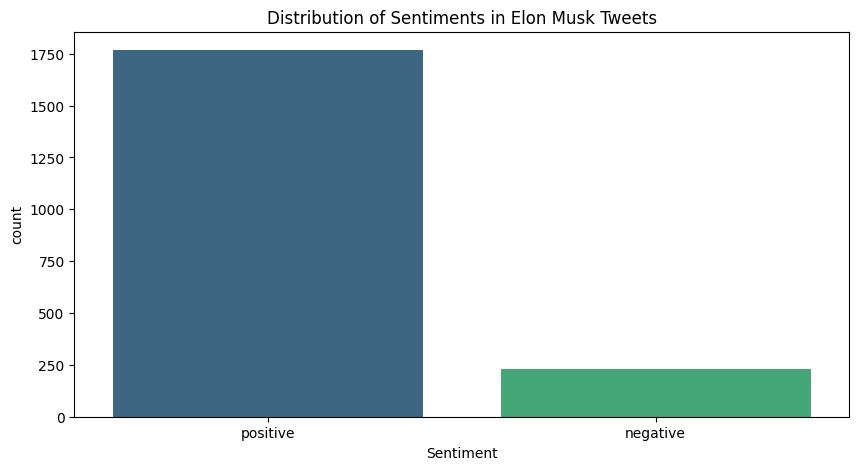

In [13]:
# Plot the distribution of sentiments
plt.figure(figsize=(10, 5))
sns.countplot(x='Sentiment', data=elon_tweets, palette='viridis')
plt.title('Distribution of Sentiments in Elon Musk Tweets')
plt.show()

Cell 14: Visualization - Word Cloud for Positive Tweets

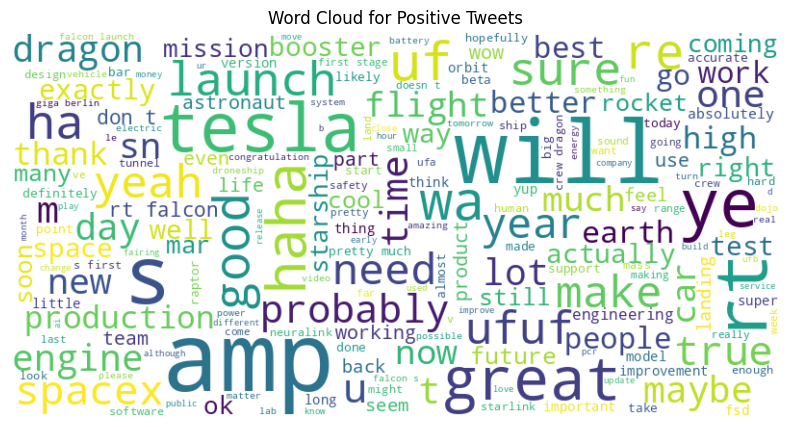

In [14]:
# Generate a word cloud for positive tweets
positive_text = ' '.join(elon_tweets['Processed_Tweets'][elon_tweets['Sentiment'] == 'positive'])
wordcloud = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Tweets')
plt.show()

Cell 15: Model Building - Data Preparation

In [15]:
# Convert sentiment labels to binary values
elon_tweets['Sentiment_Binary'] = elon_tweets['Sentiment'].apply(lambda x: 0 if x == 'negative' else 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(bow_features, elon_tweets['Sentiment_Binary'], test_size=0.3, random_state=42)

Cell 16: Model Building - Train Naive Bayes Classifier

In [16]:
# Train a Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train.toarray(), y_train)

GaussianNB()

Cell 17: Model Evaluation

Accuracy: 0.61


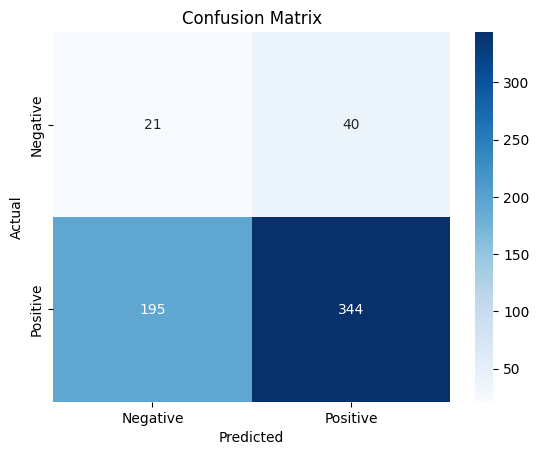

In [17]:
# Make predictions on the test set
predictions = nb_classifier.predict(X_test.toarray())

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()